In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch.optim as optim
import matplotlib.pylab as plt
rng = np.random.default_rng()
from torch.utils.data import DataLoader, TensorDataset
import tqdm

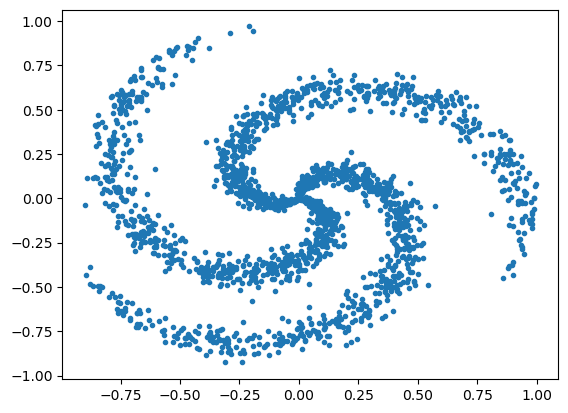

In [2]:
def generate_pinwheel(*, num: int, rng: np.random.Generator) -> np.ndarray:
    # https://github.com/Formulator/Spiral/blob/master/PyTorch_Spiral_DataLoader.ipynb
    D = 2 # dimensionality
    K = 3 # number of classes
    N = num // K  # note: we will not generate exactly num datapoints unless K divides num
    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + rng.standard_normal(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    return X
X = generate_pinwheel(num=2000, rng=rng)
plt.plot(X[:, 0], X[:, 1], '.')

In [3]:
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 8*hidden_dim)
        self.fc3 = nn.Linear(8*hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.proj1 = nn.Linear(hidden_dim, 8*hidden_dim)  
        self.proj2 = nn.Linear(8*hidden_dim, hidden_dim) 

    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        x1 = self.relu(self.fc1(x))
        x2 = self.relu(self.fc2(x1)) + self.proj1(x1) 
        x3 = self.relu(self.fc3(x2)) + self.proj2(x2) 
        return self.fc4(x3)


In [4]:
rng = np.random.default_rng(seed=69)
train_data = X
validation_data=generate_pinwheel(num=500, rng=rng)
timesteps = 1000
betas = torch.linspace(1e-4, 0.02, timesteps)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

In [6]:
def train_DDPM(train_data, validation_data, num_epochs):
    mean = np.mean(train_data, axis=0)
    std = np.std(train_data, axis=0)
    train_data = (train_data - mean) / std
    validation_data = (validation_data - mean) / std 

    train_data = torch.tensor(train_data, dtype=torch.float32)
    validation_data = torch.tensor(validation_data, dtype=torch.float32)
    train_dataset = TensorDataset(train_data)
    validation_dataset = TensorDataset(validation_data)
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

    input_dim = 2
    hidden_dim = 128 
    output_dim = 2
    model = DiffusionModel(input_dim + 1, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    train_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            batch = batch[0]
            batch_size = batch.shape[0]
            t = torch.randint(0, timesteps, (batch_size,), dtype=torch.long)
            t_embed = t.unsqueeze(-1).float() / timesteps
            noise = torch.randn_like(batch)
            noisy_batch = (
                sqrt_alphas_cumprod[t].view(-1, 1) * batch
                + sqrt_one_minus_alphas_cumprod[t].view(-1, 1) * noise)
            predicted_noise = model(noisy_batch, t_embed)
            loss = nn.MSELoss()(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_size
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            validation_loss = 0.0
            for batch in validation_dataloader:
                batch = batch[0]
                batch_size = batch.shape[0]
                t = torch.randint(0, timesteps, (batch_size,), dtype=torch.long)
                t_embed = t.unsqueeze(-1).float() / timesteps
                noise = torch.randn_like(batch)
                noisy_batch = (
                    sqrt_alphas_cumprod[t].view(-1, 1) * batch
                    + sqrt_one_minus_alphas_cumprod[t].view(-1, 1) * noise)
                predicted_noise = model(noisy_batch, t_embed)
                loss = nn.MSELoss()(predicted_noise, noise)
                validation_loss += loss.item() * batch_size
            validation_loss /= len(validation_dataset)
            validation_losses.append(validation_loss)

        if (epoch+1)%50 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

    return train_losses, validation_losses, model, std, mean

train_losses, validation_losses, model, std, mean = train_DDPM(train_data, validation_data, 600)

Epoch 50/600, Train Loss: 0.2796, Validation Loss: 0.3223
Epoch 100/600, Train Loss: 0.2845, Validation Loss: 0.2765
Epoch 150/600, Train Loss: 0.2517, Validation Loss: 0.2615
Epoch 200/600, Train Loss: 0.2915, Validation Loss: 0.2940
Epoch 250/600, Train Loss: 0.2630, Validation Loss: 0.2654
Epoch 300/600, Train Loss: 0.3019, Validation Loss: 0.2476
Epoch 350/600, Train Loss: 0.2849, Validation Loss: 0.2217
Epoch 400/600, Train Loss: 0.2579, Validation Loss: 0.1997
Epoch 450/600, Train Loss: 0.2490, Validation Loss: 0.2252
Epoch 500/600, Train Loss: 0.2760, Validation Loss: 0.2824
Epoch 550/600, Train Loss: 0.2545, Validation Loss: 0.2603
Epoch 600/600, Train Loss: 0.2635, Validation Loss: 0.2465


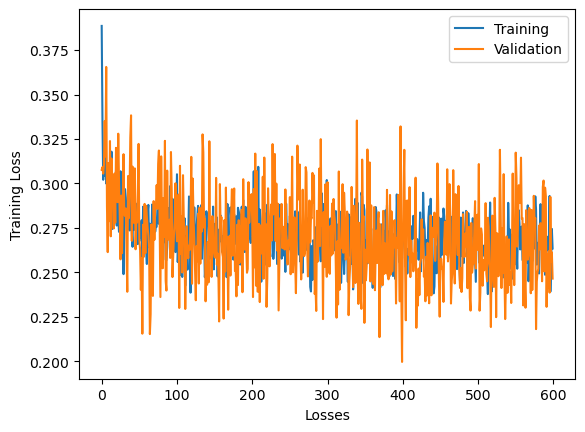

In [7]:
plt.plot(train_losses,label="Training")
plt.plot(validation_losses, label="Validation")
plt.ylabel("Training Loss")
plt.xlabel("Losses")
plt.legend(loc="upper right")
plt.show()

In [11]:
model.eval()

num_samples = 1000
x_t = torch.randn(num_samples, 2)  

for t in range(timesteps - 1, -1, -1):
    z = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)
    alpha = alphas[t]
    alpha_cumprod = alphas_cumprod[t]
    beta = betas[t]

    t_embed = torch.tensor([t / timesteps], dtype=torch.float32).repeat(num_samples, 1)
    predicted_noise = model(x_t, t_embed)

    x_t = (1 / torch.sqrt(alpha)) * (
        x_t - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
    ) + torch.sqrt(beta) * z

generated_samples = x_t.detach().numpy() * std + mean

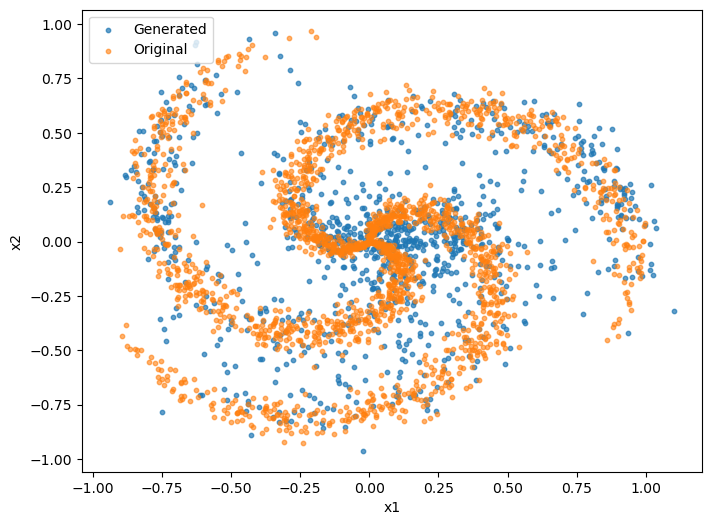

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(generated_samples[:, 0],generated_samples[:, 1],alpha=0.7,s=10,label="Generated")
plt.scatter(train_data[:, 0], train_data[:, 1], alpha=0.6, s=10,label="Original")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()

In [16]:
torch.save(model, 'ddpm_pinwheel.pth')

In [13]:
np.save("ddpm_pin.npy",generated_samples)